### Experiment: Formulation

**Question**: Which option is better?
- A 2D data formulation (`channels` * `samples`)
- A topological 3D formulation (`x` * `y` * `samples`) that positions the channels similar to their physical location

**Hypothesis**: The topological 3D formulation should have more inherent information regarding the relative location of each electrode, meaning that inter-channel similarities should be easier to extract. A topological 3D formulation should therefore be better at extracting features with regard to physical location.

**Result**:

#### Part 1: Investigation

In [1]:
import numpy as np
import pandas as pd
import mne
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt

##### Show electrode montage layout

Extracting parameters from /mnt/d/thesis/sat1/eeg4/MD3-0021.vhdr...
Setting channel info structure...


/tmp/ipykernel_11536/941089869.py:4: RuntimeWarning: The unit for channel(s) A1, A2 has changed from V to NA.
  raw.set_channel_types(
/tmp/ipykernel_11536/941089869.py:8: RuntimeWarning: Not setting positions of 2 misc channels found in montage:
['A1', 'A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage("standard_1020")  # Standard 10-20 electrode montage


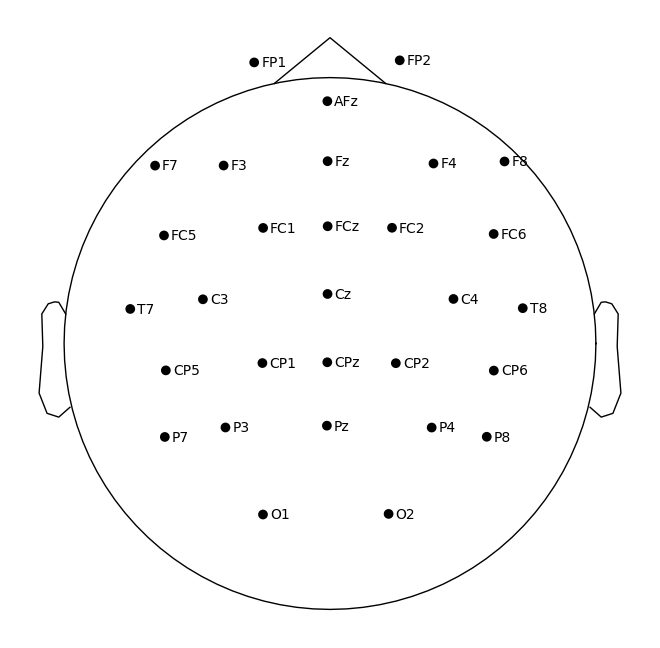

In [9]:
raw = mne.io.read_raw_brainvision(
    Path("/mnt/d/thesis/sat1/eeg4/MD3-0021.vhdr"), preload=False
)
raw.set_channel_types(
    {"EOGh": "eog", "EOGv": "eog", "A1": "misc", "A2": "misc"}
)  # Declare type to avoid confusion with EEG channels
raw.rename_channels({"FP1": "Fp1", "FP2": "Fp2"})  # Naming convention
raw.set_montage("standard_1020")  # Standard 10-20 electrode montage
raw.rename_channels({"Fp1": "FP1", "Fp2": "FP2"})

montage = raw.get_montage()
plot = montage.plot()
plt.show()

##### Replicate layout
Method of creating a sparse array retaining physical nearness adapted from Liu, Yang (2021)

In [12]:
CHANNELS_2D = np.array(
    [
        ["NA", "Fp1", "NA", "Fp2", "NA"],
        ["NA", "NA", "AFz", "NA", "NA"],
        ["F7", "F3", "Fz", "F4", "F8"],
        ["FC5", "FC1", "FCz", "FC2", "FC6"],
        ["T7", "C3", "Cz", "C4", "T8"],
        ["CP5", "CP1", "CPz", "CP2", "CP6"],
        ["P7", "P3", "Pz", "P4", "P8"],
        ["NA", "O1", "NA", "O2", "NA"],
    ],
    dtype=str,
)
print(pd.DataFrame(CHANNELS_2D))

     0    1    2    3    4
0   NA  Fp1   NA  Fp2   NA
1   NA   NA  AFz   NA   NA
2   F7   F3   Fz   F4   F8
3  FC5  FC1  FCz  FC2  FC6
4   T7   C3   Cz   C4   T8
5  CP5  CP1  CPz  CP2  CP6
6   P7   P3   Pz   P4   P8
7   NA   O1   NA   O2   NA


#### Part 2: Experiment

In [2]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import xarray as xr
from hmpai.utilities import CHANNELS_2D, print_results
from hmpai.pytorch.models import *
from hmpai.pytorch.training import k_fold_cross_validate
from hmpai.normalization import *
from hmpai.data import SAT1_STAGES_ACCURACY

In [3]:
data_path = Path("../data/sat1/split_stage_data_100hz.nc")
data = xr.load_dataset(data_path)

logs_path = Path("../logs/exp_formulation/")

height, width = CHANNELS_2D.shape
n_folds = 25
normalization_fn = norm_min1_to_1

##### Base model, no topological formulation

In [4]:
model = SAT1Base
model_kwargs = {
    "n_classes": len(data.labels),
}
train_kwargs = {
    "logs_path": Path("../logs/exp_formulation/"),
    "additional_info": {"formulation": "base"},
    "additional_name": f"formulation-base",
    "labels": SAT1_STAGES_ACCURACY,
}
results = k_fold_cross_validate(
    model,
    model_kwargs,
    data,
    n_folds,
    normalization_fn=normalization_fn,
    train_kwargs=train_kwargs,
)
print_results(results)

Fold 1: test fold: ['0009']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 1: Accuracy: 0.8867052023121387
Fold 1: F1-Score: 0.8871926967556789
Fold 2: test fold: ['0017']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 2: Accuracy: 0.847457627118644
Fold 2: F1-Score: 0.8365849384673819
Fold 3: test fold: ['0001']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 3: Accuracy: 0.8874407582938388
Fold 3: F1-Score: 0.8872666436278077
Fold 4: test fold: ['0024']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 4: Accuracy: 0.8480845442536328
Fold 4: F1-Score: 0.8508183668699919
Fold 5: test fold: ['0012']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 5: Accuracy: 0.907292954264524
Fold 5: F1-Score: 0.9104618074485534
Fold 6: test fold: ['0010']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 6: Accuracy: 0.8552147239263803
Fold 6: F1-Score: 0.8639608214524748
Fold 7: test fold: ['0014']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 7: Accuracy: 0.8796895213454075
Fold 7: F1-Score: 0.8798121858404923
Fold 8: test fold: ['0002']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 8: Accuracy: 0.867595818815331
Fold 8: F1-Score: 0.8587031816959145
Fold 9: test fold: ['0023']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 9: Accuracy: 0.9366197183098591
Fold 9: F1-Score: 0.9351016232479141
Fold 10: test fold: ['0006']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 10: Accuracy: 0.8743654822335025
Fold 10: F1-Score: 0.8763135633025192
Fold 11: test fold: ['0003']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 11: Accuracy: 0.9173967459324155
Fold 11: F1-Score: 0.921963635901822
Fold 12: test fold: ['0013']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 12: Accuracy: 0.905940594059406
Fold 12: F1-Score: 0.9074538430337167
Fold 13: test fold: ['0016']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 13: Accuracy: 0.855621301775148
Fold 13: F1-Score: 0.8614601139861733
Fold 14: test fold: ['0004']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1598/683079983.py", line 11, in <module>
    results = k_fold_cross_validate(
              ^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/c/git/hmp-ai/pkg/hmpai/pytorch/training.py", line 255, in k_fold_cross_validate
    if train_kwargs["additional_name"]:
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/c/git/hmp-ai/pkg/hmpai/pytorch/training.py", line 137, in train_and_test
    with tqdm(total=len(train_loader), unit=" batch") as tepoch:
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/c/git/hmp-ai/pkg/hmpai/pytorch/training.py", line 304, in train
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/rick/miniconda3/envs/thesis_pyto

##### Topological model without topological convolution

In [4]:
model = SAT1Topological
model_kwargs = {
    "n_classes": len(data.labels),
}
train_kwargs = {
    "logs_path": Path("../logs/exp_formulation/"),
    "additional_info": {"formulation": "topological-noconv"},
    "additional_name": f"formulation-topological-noconv",
    "labels": SAT1_STAGES_ACCURACY,
}
gen_kwargs = {"shape_topological": True}
results = k_fold_cross_validate(
    model,
    model_kwargs,
    data,
    n_folds,
    normalization_fn=normalization_fn,
    train_kwargs=train_kwargs,
    gen_kwargs=gen_kwargs,
)
print_results(results)

Fold 1: test fold: ['0009']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 1: Accuracy: 0.8730723606168446
Fold 1: F1-Score: 0.8752059187277699
Fold 2: test fold: ['0017']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 2: Accuracy: 0.8467432950191571
Fold 2: F1-Score: 0.8368104288125229
Fold 3: test fold: ['0001']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 3: Accuracy: 0.8819277108433735
Fold 3: F1-Score: 0.878042552934993
Fold 4: test fold: ['0024']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 4: Accuracy: 0.8276283618581907
Fold 4: F1-Score: 0.8313430737090247
Fold 5: test fold: ['0012']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 5: Accuracy: 0.8993788819875776
Fold 5: F1-Score: 0.9040226665027232
Fold 6: test fold: ['0010']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 6: Accuracy: 0.8576598311218335
Fold 6: F1-Score: 0.8650495227726722
Fold 7: test fold: ['0014']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

Fold 7: Accuracy: 0.8634590377113134
Fold 7: F1-Score: 0.8616775531090164
Fold 8: test fold: ['0002']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 8: Accuracy: 0.8691037735849056
Fold 8: F1-Score: 0.8590935062631451
Fold 9: test fold: ['0023']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 9: Accuracy: 0.9303944315545244
Fold 9: F1-Score: 0.928218576912121
Fold 10: test fold: ['0006']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 10: Accuracy: 0.8602673147023087
Fold 10: F1-Score: 0.8629758777724792
Fold 11: test fold: ['0003']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 11: Accuracy: 0.9181360201511335
Fold 11: F1-Score: 0.9212666424038432
Fold 12: test fold: ['0013']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 12: Accuracy: 0.8929889298892989
Fold 12: F1-Score: 0.894872717346528
Fold 13: test fold: ['0016']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 13: Accuracy: 0.8533487297921478
Fold 13: F1-Score: 0.8614848861298086
Fold 14: test fold: ['0004']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

Fold 14: Accuracy: 0.8328530259365994
Fold 14: F1-Score: 0.8354121977309392
Fold 15: test fold: ['0005']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 15: Accuracy: 0.9128878281622912
Fold 15: F1-Score: 0.9118292347476198
Fold 16: test fold: ['0021']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

Fold 16: Accuracy: 0.9506008010680908
Fold 16: F1-Score: 0.9511990803091033
Fold 17: test fold: ['0018']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 17: Accuracy: 0.8461538461538461
Fold 17: F1-Score: 0.8477848529680088
Fold 18: test fold: ['0022']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 18: Accuracy: 0.8796068796068796
Fold 18: F1-Score: 0.8840086744791755
Fold 19: test fold: ['0019']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

Fold 19: Accuracy: 0.94141689373297
Fold 19: F1-Score: 0.9413983827103791
Fold 20: test fold: ['0025']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 20: Accuracy: 0.9183417085427136
Fold 20: F1-Score: 0.9185811715239087
Fold 21: test fold: ['0008']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 21: Accuracy: 0.915129151291513
Fold 21: F1-Score: 0.9170975258857027
Fold 22: test fold: ['0011']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 22: Accuracy: 0.8985507246376812
Fold 22: F1-Score: 0.89703304547013
Fold 23: test fold: ['0015']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 23: Accuracy: 0.8991172761664565
Fold 23: F1-Score: 0.9008274156191616
Fold 24: test fold: ['0020']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

Fold 24: Accuracy: 0.8209549071618037
Fold 24: F1-Score: 0.8271030262889946
Fold 25: test fold: ['0007']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 25: Accuracy: 0.8722627737226277
Fold 25: F1-Score: 0.8725946189148631
Accuracies
[0.8730723606168446, 0.8467432950191571, 0.8819277108433735, 0.8276283618581907, 0.8993788819875776, 0.8576598311218335, 0.8634590377113134, 0.8691037735849056, 0.9303944315545244, 0.8602673147023087, 0.9181360201511335, 0.8929889298892989, 0.8533487297921478, 0.8328530259365994, 0.9128878281622912, 0.9506008010680908, 0.8461538461538461, 0.8796068796068796, 0.94141689373297, 0.9183417085427136, 0.915129151291513, 0.8985507246376812, 0.8991172761664565, 0.8209549071618037, 0.8722627737226277]
F1-Scores
[0.8752059187277699, 0.8368104288125229, 0.878042552934993, 0.8313430737090247, 0.9040226665027232, 0.8650495227726722, 0.8616775531090164, 0.8590935062631451, 0.928218576912121, 0.8629758777724792, 0.9212666424038432, 0.894872717346528, 0.8614848861298086, 0.8354121977309392, 0.9118292347476198, 0.9511990803091033, 0.8477848529680088, 0.8840086744791755, 0.9413983827103791, 0.9185811715239087, 0.91709

##### Topological model with topological convolution

In [5]:
model = SAT1TopologicalConv
model_kwargs = {
    "n_classes": len(data.labels),
}
train_kwargs = {
    "logs_path": Path("../logs/exp_formulation/"),
    "additional_info": {"formulation": "topological"},
    "additional_name": f"formulation-topological",
    "labels": SAT1_STAGES_ACCURACY,
}
gen_kwargs = {"shape_topological": True}
results = k_fold_cross_validate(
    model,
    model_kwargs,
    data,
    n_folds,
    normalization_fn=normalization_fn,
    train_kwargs=train_kwargs,
    gen_kwargs=gen_kwargs,
)
print_results(results)

Fold 1: test fold: ['0009']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 1: Accuracy: 0.8813760379596679
Fold 1: F1-Score: 0.8857790951070038
Fold 2: test fold: ['0017']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 2: Accuracy: 0.8301404853128991
Fold 2: F1-Score: 0.8235092577261213
Fold 3: test fold: ['0001']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 3: Accuracy: 0.8566265060240964
Fold 3: F1-Score: 0.8533130215144104
Fold 4: test fold: ['0024']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 4: Accuracy: 0.8056234718826406
Fold 4: F1-Score: 0.81193812225383
Fold 5: test fold: ['0012']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 5: Accuracy: 0.8981366459627329
Fold 5: F1-Score: 0.9034873234292398
Fold 6: test fold: ['0010']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 6: Accuracy: 0.8600723763570567
Fold 6: F1-Score: 0.8664705546473265
Fold 7: test fold: ['0014']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

Fold 7: Accuracy: 0.8478543563068921
Fold 7: F1-Score: 0.8493034287625122
Fold 8: test fold: ['0002']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 8: Accuracy: 0.847877358490566
Fold 8: F1-Score: 0.8459061165891715
Fold 9: test fold: ['0023']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 9: Accuracy: 0.9083526682134571
Fold 9: F1-Score: 0.9074893343596816
Fold 10: test fold: ['0006']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 10: Accuracy: 0.8602673147023087
Fold 10: F1-Score: 0.8607403672546615
Fold 11: test fold: ['0003']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 11: Accuracy: 0.9005037783375315
Fold 11: F1-Score: 0.9039682997122098
Fold 12: test fold: ['0013']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 12: Accuracy: 0.8769987699876999
Fold 12: F1-Score: 0.8822978753749157
Fold 13: test fold: ['0016']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 13: Accuracy: 0.8452655889145496
Fold 13: F1-Score: 0.854868142329245
Fold 14: test fold: ['0004']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

Fold 14: Accuracy: 0.8285302593659942
Fold 14: F1-Score: 0.8302803059292934
Fold 15: test fold: ['0005']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 15: Accuracy: 0.9116945107398569
Fold 15: F1-Score: 0.9119770632177048
Fold 16: test fold: ['0021']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

Fold 16: Accuracy: 0.9252336448598131
Fold 16: F1-Score: 0.9230609099067779
Fold 17: test fold: ['0018']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 17: Accuracy: 0.8398486759142497
Fold 17: F1-Score: 0.8403860549923545
Fold 18: test fold: ['0022']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 18: Accuracy: 0.8796068796068796
Fold 18: F1-Score: 0.8834593410973554
Fold 19: test fold: ['0019']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

Fold 19: Accuracy: 0.9400544959128065
Fold 19: F1-Score: 0.9400314463324346
Fold 20: test fold: ['0025']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 20: Accuracy: 0.8957286432160804
Fold 20: F1-Score: 0.8969852694484647
Fold 21: test fold: ['0008']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 21: Accuracy: 0.8929889298892989
Fold 21: F1-Score: 0.8914052022003943
Fold 22: test fold: ['0011']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 22: Accuracy: 0.8828502415458938
Fold 22: F1-Score: 0.8827588061716598
Fold 23: test fold: ['0015']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 23: Accuracy: 0.8965952080706179
Fold 23: F1-Score: 0.9012167982839232
Fold 24: test fold: ['0020']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

Fold 24: Accuracy: 0.7917771883289124
Fold 24: F1-Score: 0.7989468515252958
Fold 25: test fold: ['0007']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 25: Accuracy: 0.8454987834549879
Fold 25: F1-Score: 0.8411788155501263
Accuracies
[0.8813760379596679, 0.8301404853128991, 0.8566265060240964, 0.8056234718826406, 0.8981366459627329, 0.8600723763570567, 0.8478543563068921, 0.847877358490566, 0.9083526682134571, 0.8602673147023087, 0.9005037783375315, 0.8769987699876999, 0.8452655889145496, 0.8285302593659942, 0.9116945107398569, 0.9252336448598131, 0.8398486759142497, 0.8796068796068796, 0.9400544959128065, 0.8957286432160804, 0.8929889298892989, 0.8828502415458938, 0.8965952080706179, 0.7917771883289124, 0.8454987834549879]
F1-Scores
[0.8857790951070038, 0.8235092577261213, 0.8533130215144104, 0.81193812225383, 0.9034873234292398, 0.8664705546473265, 0.8493034287625122, 0.8459061165891715, 0.9074893343596816, 0.8607403672546615, 0.9039682997122098, 0.8822978753749157, 0.854868142329245, 0.8302803059292934, 0.9119770632177048, 0.9230609099067779, 0.8403860549923545, 0.8834593410973554, 0.9400314463324346, 0.8969852694484647, 0.891

View results in TensorBoard

In [6]:
# View results in Tensorboard
! tensorboard --logdir logs/exp_formulation/

2023-10-13 14:05:48.740655: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.13.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C
